In [1]:
import joblib

# Add project root to the Python path
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, cross_validate

import scipy.sparse

# access utilities

import sys
from pathlib import Path

# Adjust the system path to include the project root directory. 
# It assumes the notebook is inside 'scripts/model_training'.
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

# Import the project configuration settings.
import config

# Import the DataPreprocessingPipeline class from 'utils' in 'scripts/preprocessing'.
from utils import DataPreprocessingPipeline

In [2]:

# Use the load_data function from config to load .sas7bdat file
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

In [3]:
# Please update the below based on your specific need

# emergency_df['WAITTIME_LOG'] = np.log1p(emergency_df['WAITTIME'])
# emergency_df.drop(columns=['LOV'],inplace=True)

target = 'WAITTIME'
target_to_drop = ['WAITTIME_BINARY','LOV_BINARY']
        
# Instantiate the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df,target=target,target_to_drop=target_to_drop,percent_train=0.70,percent_val=0.15,percent_test=0.15,stratify=False)

# Run the pipeline
pipeline.run()

X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test

y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
print("Length y_test",len(y_test))

X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed

feature_names = pipeline.feature_names

cleaned_emergency_df = pipeline.cleaned_emergency_df 
transformed_emergency_df = pipeline.transformed_emergency_df

# Ensure feature_names is treated as a list
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(21893, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(21893, 386)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (15325, 386)
X_train size: (15325, 385)
y_train size: (15325,)

validation_df size: (3283, 386)
X_validation size: (3283, 385)
y_validation size: (3283,)

test_df size: (3285, 386)
X_test size: (3285, 385)
y_test size: (3285,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully
Length y_test 3285


In [4]:
X_test_preprocessed.shape

(3285, 391)

In [5]:

# Define dictionary of models with their default parameters
models_with_defaults = {
    'CatBoostRegressor': {'model': CatBoostRegressor(random_state=42, verbose=0)},
    'LinearRegression': {'model': LinearRegression()},
    'Ridge': {'model': Ridge()},
    'Lasso': {'model': Lasso()},
    'GradientBoostingRegressor': {'model': GradientBoostingRegressor(random_state=42)},
    'XGBRegressor': {'model': XGBRegressor(random_state=42)},
    'LGBMRegressor': {'model': LGBMRegressor(random_state=42, force_col_wise=True, verbosity=-1)},
}

best_model = None
best_mae = float('inf')  # Initialize with infinity
best_r2 = -float('inf')   # Initialize with negative infinity
scoring = ['neg_mean_absolute_error', 'r2']

# Prepare X_train_selected_features based on the format of X_train_preprocessed
if scipy.sparse.issparse(X_train_preprocessed):
    X_train_selected_features = X_train_preprocessed.toarray()
else:
    X_train_selected_features = X_train_preprocessed

# Loop over each model and evaluate their performance using cross-validation
for model_name, model_info in models_with_defaults.items():
    model = model_info['model']
    print(f"Cross-validating model: {model_name}...")

    # Perform cross-validation
    cv_results = cross_validate(model, X_train_selected_features, y_train, cv=5, scoring=scoring)

    # Calculate the average of the cross-validation scores
    mean_mae_validation = -1 * cv_results['test_neg_mean_absolute_error'].mean()
    mean_r2_validation = cv_results['test_r2'].mean()

    print(f"Model: {model_name}")
    print(f"Cross-Validation MAE: {mean_mae_validation:.2f}")
    print(f"Cross-Validation R-squared: {mean_r2_validation:.2f}")
    print()

    # Update best model if current model performs better based on MAE and R2
    if mean_mae_validation < best_mae and mean_r2_validation > best_r2:
        best_model = model
        best_mae = mean_mae_validation
        best_r2 = mean_r2_validation

# Display the best model based on cross-validation
print("Best Model Based on Cross-Validation:")
print(f"Model Name: {best_model.__class__.__name__}")  # Adjusted to show class name
print(f"Best Cross-Validation MAE: {best_mae:.2f}")
print(f"Best Cross-Validation R-squared: {best_r2:.2f}")

# Save the best model instance, not its name
model_filename = 'best_waittime_regression_model.joblib'
# Adjusted to directly save the model instance
joblib.dump(best_model, model_filename)
print(f"{model_filename} saved")


Cross-validating model: CatBoostRegressor...
Model: CatBoostRegressor
Cross-Validation MAE: 13.96
Cross-Validation R-squared: 0.37

Cross-validating model: LinearRegression...
Model: LinearRegression
Cross-Validation MAE: 16.05
Cross-Validation R-squared: 0.21

Cross-validating model: Ridge...
Model: Ridge
Cross-Validation MAE: 16.07
Cross-Validation R-squared: 0.21

Cross-validating model: Lasso...
Model: Lasso
Cross-Validation MAE: 17.87
Cross-Validation R-squared: 0.09

Cross-validating model: GradientBoostingRegressor...
Model: GradientBoostingRegressor
Cross-Validation MAE: 15.20
Cross-Validation R-squared: 0.30

Cross-validating model: XGBRegressor...
Model: XGBRegressor
Cross-Validation MAE: 14.54
Cross-Validation R-squared: 0.32

Cross-validating model: LGBMRegressor...
Model: LGBMRegressor
Cross-Validation MAE: 13.86
Cross-Validation R-squared: 0.38

Best Model Based on Cross-Validation:
Model Name: LGBMRegressor
Best Cross-Validation MAE: 13.86
Best Cross-Validation R-squared

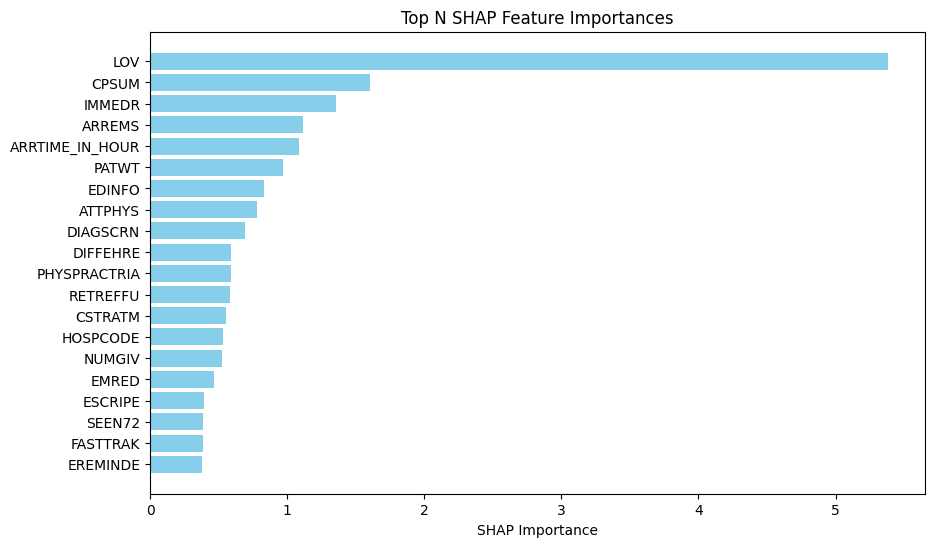

Top N Features: ['LOV', 'CPSUM', 'IMMEDR', 'ARREMS', 'ARRTIME_IN_HOUR', 'PATWT', 'EDINFO', 'ATTPHYS', 'DIAGSCRN', 'DIFFEHRE', 'PHYSPRACTRIA', 'RETREFFU', 'CSTRATM', 'HOSPCODE', 'NUMGIV', 'EMRED', 'ESCRIPE', 'SEEN72', 'FASTTRAK', 'EREMINDE']


In [6]:
# Initialize and fit the CatBoostRegressor model
model = LGBMRegressor(random_state=42, force_col_wise=True, verbosity=-1)
# model = CatBoostRegressor(random_state=42, verbose=0)
model.fit(X_train_preprocessed, y_train)

# Set the number of features needed 
n=60

    
# Get the 60 most important features 
def plot_and_return_top_n_shap(model, X_train_preprocessed, feature_names, n=n):
    """
    Calculates SHAP values, plots the top N features with cleaned names, and returns their names without prefixes.

    Parameters:
    - model: The trained model.
    - X_train_preprocessed: The preprocessed training data.
    - feature_names: Names of the features after preprocessing.
    - n: Number of top features to plot and return.

    Returns:
    - List of names of the top N features based on SHAP values, without 'num__' and 'cat__' prefixes.
    """
    # Initialize the SHAP Tree explainer and compute SHAP values.
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_preprocessed)

    # Calculate the mean absolute SHAP values for each feature.
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame(list(zip(feature_names, shap_sum)), columns=['feature_name', 'shap_importance'])
    importance_df.sort_values(by='shap_importance', ascending=False, inplace=True)

    # Clean the feature names by removing prefixes.
    importance_df['feature_name'] = importance_df['feature_name'].str.replace(r'^(num__|cat__)', '', regex=True)

    # Plot the top N important features with cleaned names.
    top_features_df = importance_df.head(n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features_df['feature_name'], top_features_df['shap_importance'], color='skyblue')
    plt.xlabel('SHAP Importance')
    plt.title('Top N SHAP Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

    # Return the names of the top N features without prefixes.
    return top_features_df['feature_name'].tolist()

# Call the function with real feature names.
top_features = plot_and_return_top_n_shap(
    model=model,
    X_train_preprocessed=X_train_preprocessed,
    feature_names=feature_names_list,
    n=20  # Adjust this value based on how many top features you wish to examine.
)

print("Top N Features:", top_features)
# Extracting indices of top features directly since prefixes have been removed
top_feature_indices = [feature_names_list.index(feature) for feature in top_features]

X_train_selected_features = X_train_preprocessed[:, top_feature_indices]
X_validation_selected_features = X_validation_preprocessed[:, top_feature_indices] if X_validation_preprocessed.size > 0 else X_validation_preprocessed
X_test_selected_features = X_test_preprocessed[:, top_feature_indices]

# Save top n features  
config.save_data(top_features, f"top_features_{target}.csv", 'features')
config.save_data(top_feature_indices, f"feature_indices_{target}.csv", 'features')

config.save_data(X_train_selected_features, f"X_train_selected_features_{target}.csv", subdir='train',column_names=top_features)
config.save_data(X_validation_selected_features, f"X_validation_selected_features_{target}.csv", subdir='validation',column_names=top_features)
config.save_data(X_test_selected_features, f"X_test_selected_features_{target}.csv", subdir='test',column_names=top_features)

